In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge # regularized linear regression
from sklearn.ensemble import RandomForestRegressor # random forest regressor
from sklearn.neural_network import MLPRegressor # neural network regressor
from sklearn.model_selection import GridSearchCV

In [38]:
import pandas as pd
from sklearn.decomposition import PCA

df = pd.read_csv("./train.csv")

## Outlier Detection and Standardization

In [39]:
# Drop the outliers using Z-score
z_scores = np.abs(stats.zscore(df))
threshold = 5
outliers = np.where(z_scores > threshold)
df = df.drop(outliers[0])
print(df.shape)

(7917, 41)


In [40]:
# Separate features and target
X = df.iloc[:, :-1]  # First 40 columns (features)
y = df.iloc[:, -1]   # Last column (target)

In [41]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

standard_scaler_features = ['acc_rate', 'track', 'n', 'current_pitch', 'current_roll', 
                            'climb_delta', 'roll_rate_delta', 'climb_delta_diff']

robust_scaler_features = ['m', 'absoluate_roll', 'time1', 'time2', 'time3', 'time4', 'time5', 
                          'time6', 'time7', 'time8', 'time9', 'time10', 'time11', 'time12', 
                          'time13', 'time14', 'omega', 'set']

minmax_scaler_features = ['time1_delta', 'time2_delta', 'time3_delta', 'time4_delta', 
                          'time5_delta', 'time6_delta', 'time7_delta', 'time8_delta', 
                          'time9_delta', 'time10_delta', 'time11_delta', 'time12_delta', 
                          'time13_delta', 'time14_delta']

column_trans = ColumnTransformer([
    ("standard", StandardScaler(), standard_scaler_features),
    ("robust", RobustScaler(), robust_scaler_features),
    ("minmax", MinMaxScaler(feature_range=(-1,1)), minmax_scaler_features)
])

X = column_trans.fit_transform(X)

## Dimensionality Reduction with PCA (Two Components)

In [42]:
pca_vis = PCA(n_components=2)  # Reducing to 2 dimensions
X_pca_vis = pca_vis.fit_transform(X)  # Fit PCA on the entire dataset
print("Explained variance ratio:", pca_vis.explained_variance_ratio_)

Explained variance ratio: [0.74924216 0.06389727]


## 3D Scatter Plot of Principal Component

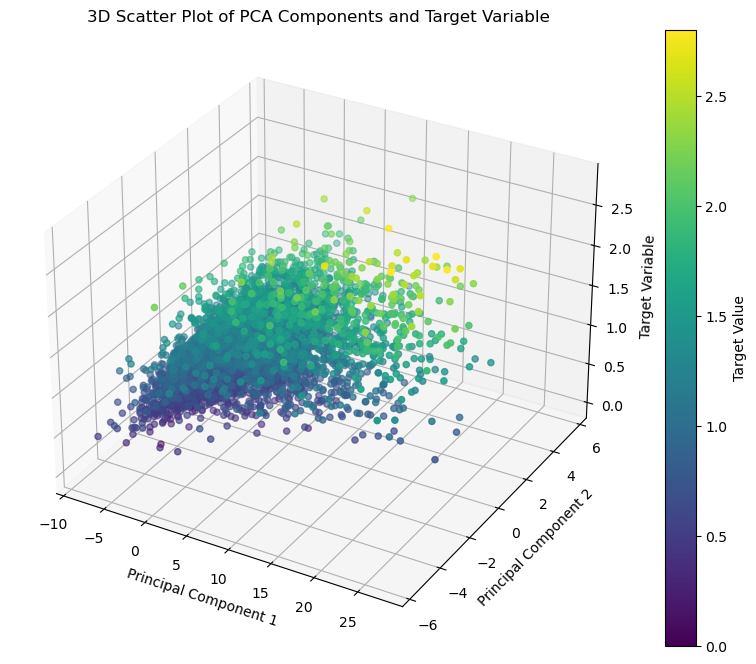

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plotting the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')    
scatter = ax.scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], y, c=y, cmap='viridis')
# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Target Variable')
ax.set_title('3D Scatter Plot of PCA Components and Target Variable')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Target Value')

plt.savefig("./images/3D_Scatter_Plot", dpi=300, bbox_inches='tight')
plt.show()

## 2D Visualization of Principal Component

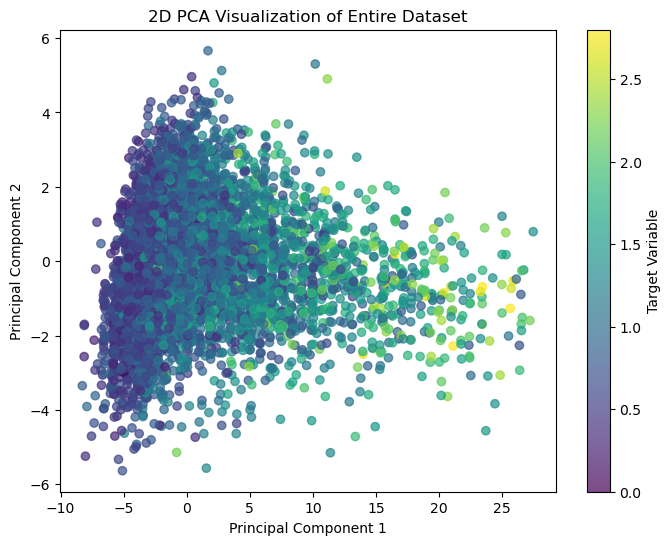

In [44]:
import seaborn as sns

plt.figure(figsize=(8, 6))
# sns.kdeplot(x=X_pca_vis[:, 0], y=X_pca_vis[:, 1], cmap="coolwarm", fill=True, alpha=0.5)
scatter = plt.scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], c=y, cmap="viridis", alpha=0.7)
plt.colorbar(label="Target Variable")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Visualization of Entire Dataset")

plt.savefig("./images/2D_Scatter_Plot.png", dpi=300, bbox_inches='tight')
plt.show()

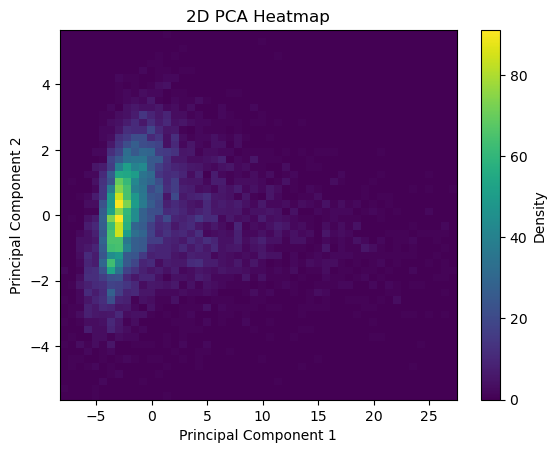

In [45]:
plt.hist2d(X_pca_vis[:, 0], X_pca_vis[:, 1], bins=50, cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Heatmap")
plt.savefig("./images/2D_Heatmap.png")
plt.show()

## 10-Fold Cross-Validation on PCA-Transformed Data with ANN

In [46]:
from sklearn.decomposition import PCA

X_train = pd.read_csv('datasets/X_train.csv')
X_test = pd.read_csv('datasets/X_test.csv')
y_train = pd.read_csv('datasets/y_train.csv').values.ravel()
y_test = pd.read_csv('datasets/y_test.csv').values.ravel()

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [47]:
output_dir = 'PCA_transformed_features'

# Save to a CSV file
pd.DataFrame(X_train_pca, columns=['PC1', 'PC2']).to_csv(f'{output_dir}/X_train_pca.csv', index=False)
pd.DataFrame(X_test_pca, columns=['PC1', 'PC2']).to_csv(f'{output_dir}/X_test_pca.csv', index=False)
pd.DataFrame(y_train, columns=['label']).to_csv(f'{output_dir}/y_train_pca.csv', index=False)
pd.DataFrame(y_test, columns=['label']).to_csv(f'{output_dir}/y_test_pca.csv', index=False)

In [48]:
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="viridis")
# plt.colorbar(label="Target Variable")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("2D PCA Visualization")
# plt.show()

In [49]:
# Define parameter grids for each model
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_rf = {'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 10, 20, 30]}
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (50, 50, 50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs']
}

In [50]:
# Perform Grid Search for Ridge Regression
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

In [51]:
# Perform Grid Search for Random Forest
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [52]:
# Perform Grid Search for Neural Network
mlp = MLPRegressor(random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_

c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [53]:
print(best_mlp)

MLPRegressor(activation='tanh', hidden_layer_sizes=(50,), random_state=42,
             solver='lbfgs')


In [54]:
# Store best models
models = {
    "Best Ridge Regression": best_ridge,
    "Best Random Forest Regressor": best_rf,
    "Best Neural Network": best_mlp
}

In [55]:
model = models["Best Neural Network"]

# scores_pca_2d = cross_val_score(model, X_train_pca, y_train, cv=10, scoring="neg_mean_squared_error")

# print("Mean Cross-Validation MSE with PCA (2D):", -scores_pca_2d.mean

model.fit(X_train_pca, y_train.ravel())

scores_pca_2d = cross_val_score(model, X_train_pca, y_train, cv=10, scoring="neg_mean_squared_error")

score_r2_2d = model.score(X_test_pca, y_test)

print("Mean Cross-Validation MSE with PCA (2D):", -scores_pca_2d.mean())
print("R^2 Score for Neural Network (PCA 2D):", score_r2_2d)

c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Mean Cross-Validation MSE with PCA (2D): 0.09058296827730568
R^2 Score for Neural Network (PCA 2D): 0.44765241355268914


c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Optimal Component Selection for PC

In [56]:
pca_full = PCA().fit(X_train)
explained_variance_ratio = pca_full.explained_variance_ratio_.cumsum()
print(explained_variance_ratio)

num_components = (explained_variance_ratio >= 1 - 1e-6).argmax() + 1
# print(num_components, explained_variance_ratio[num_components - 1])
print(f"Optimal number of PCA components: {num_components}")

[0.75165658 0.81437731 0.87399624 0.9121828  0.93687225 0.9538453
 0.96734878 0.97706188 0.9849307  0.98902419 0.99162533 0.99350001
 0.99490351 0.99612262 0.99712805 0.99798175 0.99876602 0.9994531
 0.99968385 0.99978189 0.9998552  0.99990535 0.9999398  0.99996619
 0.99998643 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
Optimal number of PCA components: 26


## 10-Fold Cross-Validation on Optimized PCA-Transformed Data with ANN

In [57]:
pca_optimal = PCA(n_components=num_components)
X_train_pca_opt = pca_optimal.fit_transform(X_train)
X_test_pca_opt = pca_optimal.transform(X_test)

# scores_pca_opt = cross_val_score(model, X_train_pca_opt, y_train, cv=10, scoring="neg_mean_squared_error")

# print("Mean Cross-Validation MSE with Optimal PCA:", -scores_pca_opt.mean())

model.fit(X_train_pca_opt, y_train.ravel())

scores_pca_opt = cross_val_score(model, X_train_pca_opt, y_train, cv=10, scoring="neg_mean_squared_error")

score_r2_opt = model.score(X_test_pca_opt, y_test)

print("Mean Cross-Validation MSE with Optimal PCA:", -scores_pca_opt.mean())
print("R^2 Score for Neural Network with Optimal PCA:", score_r2_opt)

c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Mean Cross-Validation MSE with Optimal PCA: 0.025772656978237673
R^2 Score for Neural Network with Optimal PCA: 0.8161017828167267


c:\Users\Zhy20\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [58]:
# Save to a CSV file
pd.DataFrame(X_train_pca_opt).to_csv(f'{output_dir}/X_train_pca_opt.csv', index=False)
pd.DataFrame(X_test_pca_opt).to_csv(f'{output_dir}/X_test_pca_opt.csv', index=False)
pd.DataFrame(y_train, columns=['label']).to_csv(f'{output_dir}/y_train_pca_opt.csv', index=False)
pd.DataFrame(y_test, columns=['label']).to_csv(f'{output_dir}/y_test_pca_opt.csv', index=False)